In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

## Automl 로 feature importance 파악

Pycaret이라는 Automl 패키지입니다. 매우 간단하고 사용하기 좋아서, 맨 처음 어떤식으로 데이콘을 시작해야하는지 어렵다면 시도하기 좋습니다.

In [2]:
from pycaret.classification import *
from sklearn.metrics import log_loss

In [21]:
raw_data = pd.read_csv('train.csv')

In [4]:
clf = setup(raw_data, target = 'credit')


,Description,Value
0,session_id,6483
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 20)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,13
8,Ordinal Features,False
9,High Cardinality Features,False


In [5]:
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x000002A17FE505E0>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [6]:
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
svm,SVM - Linear Kernel,0.3989,0.0000,0.3333,0.1997,0.2561,0.0000,0.0000,0.0000,0.2600
ridge,Ridge Classifier,0.6465,0.0000,0.3356,0.5396,0.5110,0.0066,0.0362,0.0000,0.0360
xgboost,Extreme Gradient Boosting,0.7024,0.7007,0.4459,0.6805,0.6401,0.2644,0.3253,0.7696,2.1260
lightgbm,Light Gradient Boosting Machine,0.7003,0.6868,0.4242,0.6944,0.6238,0.2351,0.3172,0.7738,0.3220
gbc,Gradient Boosting Classifier,0.6950,0.6457,0.4097,0.6653,0.6106,0.2106,0.2998,0.7937,1.6540
lda,Linear Discriminant Analysis,0.6465,0.6019,0.3375,0.5312,0.5149,0.0123,0.0456,0.8596,0.0840
nb,Naive Bayes,0.6460,0.6035,0.3338,0.4779,0.5077,0.0018,0.0162,0.8600,0.5180
lr,Logistic Regression,0.6458,0.5693,0.3333,0.4170,0.5068,0.0000,0.0000,0.8707,0.8180
rf,Random Forest Classifier,0.6950,0.7319,0.5282,0.6717,0.6771,0.3515,0.3585,0.9969,0.4200
ada,Ada Boost Classifier,0.6939,0.6207,0.4049,0.6851,0.6057,0.2006,0.2980,1.0808,0.1920


In [9]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7057,0.7125,0.4484,0.6873,0.6433,0.2723,0.3350,0.7634
1,0.7068,0.7132,0.4473,0.6816,0.6439,0.2767,0.3377,0.7521
2,0.7133,0.7055,0.4523,0.6954,0.6500,0.2900,0.3574,0.7580
3,0.7025,0.7072,0.4436,0.6721,0.6397,0.2674,0.3246,0.7653
4,0.7046,0.7041,0.4466,0.6826,0.6416,0.2686,0.3323,0.7733
5,0.7111,0.7144,0.4546,0.7043,0.6492,0.2836,0.3515,0.7521
6,0.7090,0.7078,0.4459,0.7002,0.6430,0.2719,0.3448,0.7606
7,0.6944,0.6987,0.4333,0.6737,0.6270,0.2373,0.2994,0.7690
8,0.6992,0.6991,0.4377,0.6728,0.6334,0.2522,0.3150,0.7692
9,0.6980,0.7051,0.4324,0.6673,0.6299,0.2441,0.3115,0.7651


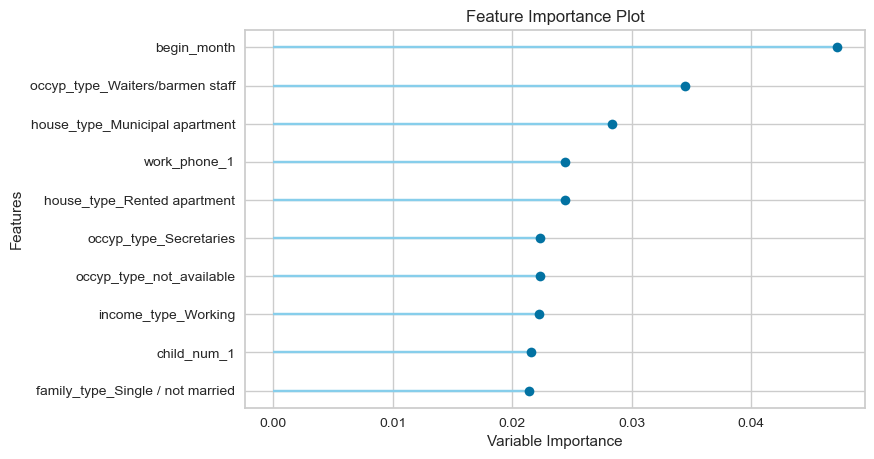

In [12]:
plot_model(estimator = xgboost, plot = 'feature')

Begin_month라는 feature가 상당히 큰 영향을 차지하는 편. (물론 크지는 않다)


## 데이터 뜯어보기

In [15]:
train = raw_data

train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,7705.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,12446.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,19431.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,25152.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [17]:
train.isnull().sum() 

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

=> NULL 값 == 백수?

1. 우선 데이터 중에 childnum 항목을 보면..대체 child max가 19인건...??? 축구단??

2. Days_employed 부분도 양수는 분명히 오차값. 문제가 있는 것이다.

3. family_size가 20.0인건 아무리봐도 오류같다.

=>이거 3개를 위주로 한번 봐야한다..

https://dacon.io/competitions/official/235713/codeshare/2494?page=1&dtype=vote

여기 내용을 참고해보니, Feature_importance가 높은 feature들은 분명히 연체 이력에 어느정도 영향력을 미침

## 중복인원에 관한 고찰? =>이것의 영향력?

EDA는 해리님이 잘 설명해주실 테니까..(?)

모델의 정확도를 높이는 쪽으로 설명을 하려고 함

In [18]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 3209명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 5518명


=>크게 영향력 없음


## 결측치, 중복치 처리해보고 + 몇가지 EDA  실행

In [19]:
#NAN 채우기
train.fillna('NaN', inplace=True) 

#FamilySize가 7보다 큰건 뺀다는데 이유는
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)


In [22]:
data = raw_data

## 가족과 아이 그리고 일수? 에 관한 몇가지 EDA

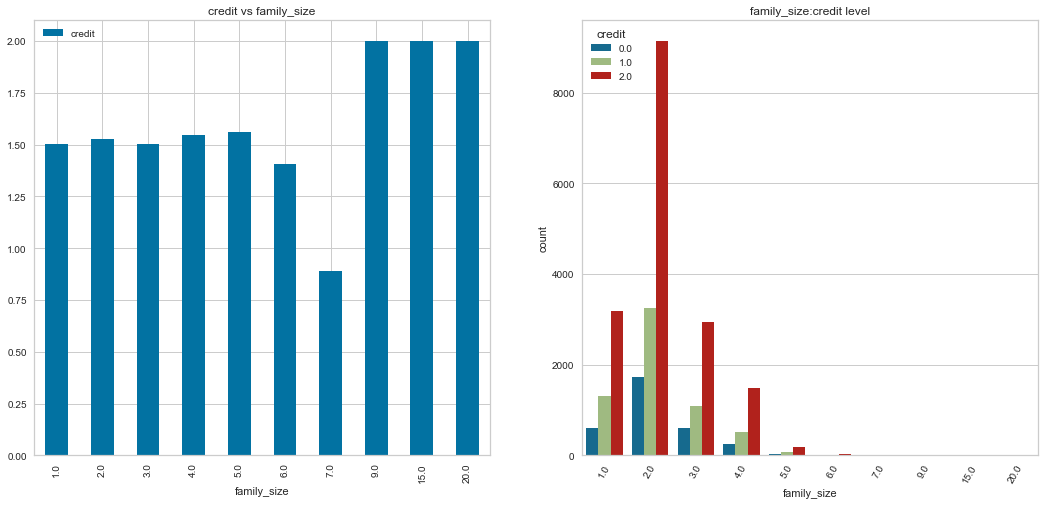

In [23]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['family_size','credit']].groupby(['family_size']).mean().plot.bar(ax=ax[0])
ax[0].set_title('credit vs family_size')
sns.countplot('family_size',hue='credit',data=data,ax=ax[1])
ax[1].set_title('family_size:credit level')
plt.xticks(rotation=60)
plt.show()

7이상의 가구는 데이터가 적다! 그리고 Outlier로 판단했다고 하네? 

In [24]:
pd.crosstab(data.credit,data.family_size,margins=True).style.background_gradient(cmap='summer_r')

family_size,1.0,2.0,3.0,4.0,5.0,6.0,7.0,9.0,15.0,20.0,All
credit,,,,,,,,,,,
0.0,605,1720,610,251,27,7,2,0,0,0,3222
1.0,1318,3249,1088,520,74,12,6,0,0,0,6267
2.0,3186,9137,2934,1489,190,25,1,2,3,1,16968
All,5109,14106,4632,2260,291,44,9,2,3,1,26457


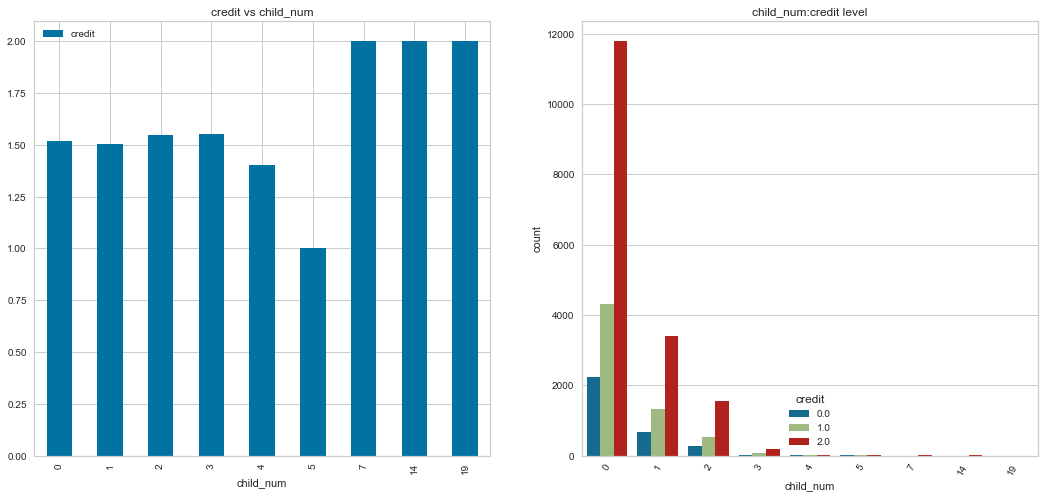

In [25]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['child_num','credit']].groupby(['child_num']).mean().plot.bar(ax=ax[0])
ax[0].set_title('credit vs child_num')
sns.countplot('child_num',hue='credit',data=data,ax=ax[1])
ax[1].set_title('child_num:credit level')
plt.xticks(rotation=60)
plt.show()

In [26]:
pd.crosstab(data.credit,data.child_num,margins=True).style.background_gradient(cmap='summer_r')

child_num,0,1,2,3,4,5,7,14,19,All
credit,,,,,,,,,,
0.0,2233,682,268,29,8,2,0,0,0,3222
1.0,4322,1313,535,79,12,6,0,0,0,6267
2.0,11785,3391,1559,198,27,2,2,3,1,16968
All,18340,5386,2362,306,47,10,2,3,1,26457


역시나 5 위로는 거의 없다!

그리고 추가적인 Comment로, child와 family size에 관한 상당한 유사성이 보여서 '파생변수' 라는 용어로 설명을 함

데이터 내부의 새로운 변수로, 사실상 Drop을 해도 괜찮은 친구이다

## 1등의 powerful한 솔루션, Date를 세밀화했다?

<img src="1등의 전략.png">

=>근데 이게 큰 상관이 있나? => 구글 선생님께 물어보자!

https://stackoverflow.com/questions/46428870/how-to-handle-date-variable-in-machine-learning-data-pre-processing

여기에 나온 내용에 따르면, 날짜를 아래와 같은 항목들로 새롭게 변경하는건 괜찮은 접근이라고 한다!

weekends vs weekdays

business hours and time of day

seasons

week of year number

month

year

beginning/end of month (pay days)

quarter

days to/from an action event(distance)

missing or incomplete data

https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning

아마도 좀 더 쉬운 접근을 위해서 이렇게 진행한 것이겠죠??

## Automl 로 EDA후 다시 돌려보기

머리 아파서 나중에 추가해보겠습니다..